#Downloading images

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Download a file based on its file ID.
#
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
file_id_1 = '1nx8oTD1mdhB9e19xAZQYsdgOPt-4QUvl'  
downloaded_1 = drive.CreateFile({'id': file_id_1})  

In [0]:
file_id_2 = '1OSrIuKWasvLss0Ewbx5EyTEPKSQ1nM6k'  
downloaded_2 = drive.CreateFile({'id': file_id_2}) 

In [0]:
downloaded_1.GetContentFile('train.zip')

In [0]:
downloaded_2.GetContentFile('test.zip')

In [0]:
!unzip train.zip

In [0]:
!unzip test.zip

#Downloading trained model

In [0]:
file_id_mlruns = '1vu6d7ZKBwMQ_v4QpnAB72n-SG1zuul3V'  
downloaded_mlruns = drive.CreateFile({'id': file_id_mlruns})

In [0]:
downloaded_mlruns.GetContentFile('mlruns.zip')

In [0]:
!unzip mlruns.zip

#Importing libraries and setting up GPU

In [0]:
!pip install mlflow

In [0]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook 
import copy
import glob

import torch
import torchvision
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchvision import datasets

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import pandas as pd

import mlflow
import mlflow.pytorch

import cv2

In [13]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


#Mask generation for annotated images

In [0]:
def mask_generator(source_file_path, dest_file_path):
    file_names = sorted([file for _,_,files in os.walk(source_file_path) for file in files])
    for i, file_name in enumerate(file_names):
        if i % 2 != 0:
            im = cv2.imread(source_file_path+file_name)
            imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            ret,thresh = cv2.threshold(imgray,127,255,0)
            im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
            ellipse = cv2.fitEllipse(contours[0])
            im1 = cv2.ellipse(im,ellipse,(255,255,255),-1)
            image_name = file_name.replace('Annotation', 'Mask')
            cv2.imwrite(dest_file_path+image_name, im1)
    
    return 1

#Dataloader

In [0]:
#For converting the dataset to torchvision dataset format
class HC18Dataset(Dataset):
    def __init__(self, file_path,train=True):        
        self.file_path = file_path
        self.train = train
        if self.train:
            self.transform_x = transforms.Compose([
                transforms.Resize((432, 640)), 
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.transform_y = transforms.Compose([
                    transforms.Resize((432, 640)), 
                    transforms.ToTensor()
            ])
            self.X_train_file_names = []
            self.Y_train_file_names = []
            file_names = sorted([file for _,_,files in os.walk(self.file_path) for file in files])
            for i, file_name in enumerate(file_names):
                if i % 2 == 0:
                    self.X_train_file_names.append(file_name)
                else:
                    self.Y_train_file_names.append(file_name)
            self.len = len(self.X_train_file_names)
            
        else:
            self.transform_x = transforms.Compose([
                transforms.Resize((432, 640)),
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,))
            ])
            self.X_test_file_names = sorted([file for _,_,files in os.walk(self.file_path) for file in files])
            self.len = len(self.X_test_file_names)
            
            
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):        
        if self.train:
            X_train_file_name = self.X_train_file_names[index]
            Y_train_file_name = self.Y_train_file_names[index]
            x_train = self.pil_loader(self.file_path+"/"+X_train_file_name)
            y_train = self.pil_loader(self.file_path+"/"+Y_train_file_name)
            return self.transform_x(x_train), self.transform_y(y_train), X_train_file_name, Y_train_file_name
        else:
            file_name = self.X_test_file_names[index]
            x_test = self.pil_loader(self.file_path+"/"+file_name)
            return self.transform_x(x_test), file_name
                
    def pil_loader(self,path):
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('L')


In [0]:
full_data = HC18Dataset("train",train=True)

In [0]:
train_size = int(0.9 * len(full_data))
test_size = len(full_data) - train_size

train_data, validation_data = random_split(full_data, [train_size, test_size])

In [0]:
batch_size = 2

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, shuffle=True)

In [0]:
test_data = HC18Dataset("test",train=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False)

In [0]:
def imshow(img, title):
    npimg = img.numpy() *0.5 + 0.5   # un-normalizing the image
    plt.figure(figsize=(batch_size*5, 5))
    #plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

In [0]:
def show_train_batch_images(dataloader):
    x, y, xf, yf = next(iter(dataloader))
    x = torchvision.utils.make_grid(x)
    y = torchvision.utils.make_grid(y)
    imshow(x, title=[n for n in xf])
    imshow(y, title=[n for n in yf])

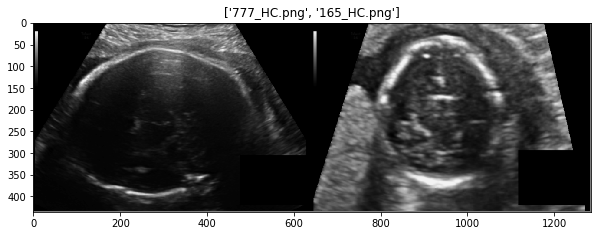

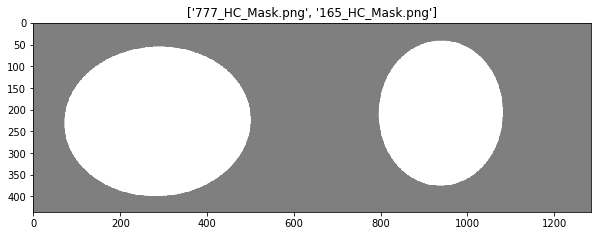

In [29]:
show_train_batch_images(validation_loader)

#Model

In [0]:
class UNet(nn.Module):
    def __init__(self): 
        super(UNet, self).__init__()
        self.down_sample_conv_1 = self.down_sample_conv(1)
        self.down_sample_conv_2 = self.down_sample_conv(64)
        self.down_sample_conv_3 = self.down_sample_conv(128)
        self.down_sample_conv_4 = self.down_sample_conv(256)
        self.down_sample_conv_5 = self.down_sample_conv(512)
        
        self.upconv_4 = self.up_conv(1024)
        self.up_sample_conv_4 = self.up_sample_conv(1024)
        self.upconv_3 = self.up_conv(512)
        self.up_sample_conv_3 = self.up_sample_conv(512)
        self.upconv_2 = self.up_conv(256)
        self.up_sample_conv_2 = self.up_sample_conv(256)
        self.upconv_1 = self.up_conv(128)
        self.up_sample_conv_1 = self.up_sample_conv(128)
        
        self.final_conv = nn.Conv2d(64, 2, kernel_size=1, stride=1, padding=0)
    
    def down_sample_conv(self, in_feature_maps):
        return nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        ) if in_feature_maps == 1 else nn.Sequential(
            nn.Conv2d(in_feature_maps, 2*in_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(2*in_feature_maps, 2*in_feature_maps, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        )
      
    def down_sample(self):
        return nn.MaxPool2d(kernel_size=2, stride=2)
      
    def up_sample_conv(self, in_feature_maps):
        return nn.Sequential(
            nn.Conv2d(in_feature_maps, int(0.5*in_feature_maps), kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(int(0.5*in_feature_maps), int(0.5*in_feature_maps), kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True)
            
        )
      
    def up_conv(self, in_feature_maps):
        return nn.ConvTranspose2d(in_feature_maps, int(0.5*in_feature_maps), kernel_size=2, stride=2, padding=0)
      
    def crop_concat(self, x1, x2):
        in_width = x1.shape[-1]
        out_width = x2.shape[-1]
        crop_width = (in_width - out_width) // 2
        
        in_height = x1.shape[-2]
        out_height = x2.shape[-2]
        crop_height = (in_height - out_height) // 2
        
        x1 = x1[:, :, crop_height:(in_height-crop_height), crop_width:(in_width-crop_width)]
        return torch.cat((x1, x2), 1)
        
    def forward(self, x):
        #Downsampling or contraction
        x1 = self.down_sample_conv_1(x)
        #print(x1.shape)
        x2 = self.down_sample_conv_2(self.down_sample()(x1))
        #print(x2.shape)
        x3 = self.down_sample_conv_3(self.down_sample()(x2))
        #print(x3.shape)
        x4 = self.down_sample_conv_4(self.down_sample()(x3))
        #print(x4.shape)
        x5 = self.down_sample_conv_5(self.down_sample()(x4))
        #print(x5.shape)
        #print('--------------------------------------------------\n')
        
        #Upsampling or expansion
        x4_u = self.upconv_4(x5)
        x4_u = self.up_sample_conv_4(self.crop_concat(x4, x4_u))
        #print(x4_u.shape)
        x3_u = self.upconv_3(x4_u)
        x3_u = self.up_sample_conv_3(self.crop_concat(x3, x3_u))
        #print(x3_u.shape)
        x2_u = self.upconv_2(x3_u)
        x2_u = self.up_sample_conv_2(self.crop_concat(x2, x2_u))
        #print(x2_u.shape)
        x1_u = self.upconv_1(x2_u)
        x1_u = self.up_sample_conv_1(self.crop_concat(x1, x1_u))
        #print(x1_u.shape)
        y = self.final_conv(x1_u)
        #print(y.shape)           
        return y

#Training and Validation

In [0]:
def train(epoch):
    
    model.train()
    
    for batch_id, data in enumerate(train_loader):
        inputs, targets, _, _ = data               
        
        tragets = torch.ceil(targets)     
        inputs = inputs.to(device)
        targets = targets.to(device)
        targets = targets.view(targets.shape[0], targets.shape[2], targets.shape[3]).long()
                
        opt.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        opt.step()
        
        if batch_id % args.log_interval == 0:
            #pos = epoch * len(train_loader) + batch_id
            #mlflow.log_metric('train_loss', loss.data.item())            
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
                epoch, batch_id * len(inputs), len(train_loader.dataset),
                100. * batch_id / len(train_loader), loss.data.item()))
        
        del inputs, targets, outputs, loss
        torch.cuda.empty_cache()

In [0]:
def validate(epoch):
    
    model.eval()
    validation_loss = 0
    
    with torch.no_grad():
        
        for inputs, targets, _, _ in validation_loader:
          
            tragets = torch.ceil(targets)
            inputs = inputs.to(device)
            targets = targets.to(device)
            targets = targets.view(targets.shape[0], targets.shape[2], targets.shape[3]).long()
            
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            validation_loss += loss.data.item()        
            
            del inputs, targets, outputs
            torch.cuda.empty_cache()
            
        validation_loss /= len(validation_loader.dataset)
        
        #pos = (epoch + 1) * len(train_loader)
        #mlflow.log_metric('validation_loss', validation_loss)
        
        print('\nEpoch: {}, Validation set: Average loss: {:.4f}\n'.
              format(epoch, validation_loss))  
        
        return validation_loss


In [0]:
class Params(object):
    def __init__(self, batch_size, epochs, seed, log_interval):
        self.batch_size = batch_size
        self.epochs = epochs
        self.seed = seed
        self.log_interval = log_interval

args = Params(batch_size, 10, 0, 15)

In [0]:
#best_model = None

In [0]:
expt_name = 'HC18_CrossEntropy_A8'
expt_id = mlflow.create_experiment(expt_name)

mlflow.set_experiment(expt_name)

lr = 0.015
momentum = 0.9

expt_id = '%d_%d' % (int(lr*1000), int(momentum*1000))

print('\nLR = %.3f, Momentum = %.3f\n' % (lr, momentum))

if best_model:
    model.load_state_dict(best_model)
else:
    min_validation_loss = np.inf
    torch.manual_seed(args.seed)
    model = UNet()
    model.to(device)

loss_fn = nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr=lr, momentum = momentum, nesterov=True)

with mlflow.start_run(nested=True) as run:                
    for key, value in vars(args).items():
        mlflow.log_param(key, value)
    mlflow.log_param('lr', lr)
    mlflow.log_param('momentum', momentum)

    for epoch in tqdm_notebook(range(1, args.epochs + 1), total=args.epochs, unit="epoch"):
        train(epoch)
        validation_loss = validate(epoch)

        if validation_loss < min_validation_loss:
            min_validation_loss = validation_loss
            best_model = copy.deepcopy(model.state_dict())            

        print("Minimun validation loss so far: {:.3f}\n\n".format(min_validation_loss))   
        
    model.load_state_dict(best_model)
    mlflow.pytorch.log_model(model, "models")
    

In [0]:
!tar -czvf mlruns.tar.gz mlruns/8/609ab859607142278e6f4b54f1f5793e

#Validation loss

In [0]:
model = mlflow.pytorch.load_model('mlruns/8/609ab859607142278e6f4b54f1f5793e/artifacts/models')


In [28]:
loss_fn = nn.CrossEntropyLoss()
validate(1)


Epoch: 1, Validation set: Average loss: 0.0193



0.01928541114553809

#Segmentation

In [0]:
model = mlflow.pytorch.load_model('mlruns/8/609ab859607142278e6f4b54f1f5793e/artifacts/models')

In [0]:
!mkdir test_segmented/

In [0]:
!ls test_segmented/

In [0]:
def segment():
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((540, 800)),
        transforms.ToTensor()
        ])    
    
    for inputs, file_names in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        outputs = outputs.argmax(1).int()
        for i, file_name in enumerate(file_names):    
            output = transform(outputs[i].to('cpu'))
            torchvision.utils.save_image(output, 'test_segmented/{}_Mask.png'.format(file_name.replace('.png', '')))            
        del inputs, outputs
        torch.cuda.empty_cache()
        
    return 1

In [0]:
segment()

1

In [0]:
!tar -czvf test_segmented.tar.gz test_segmented/

#Rough code 

In [0]:
model.load_state_dict(best_model)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
x, y, _, _ = next(iter(validation_loader))
x = x.to(device)
y = y.to(device)
yp = model(x)

In [0]:
yp = yp.to('cpu').data.detach()
y = y.to('cpu').data.detach()

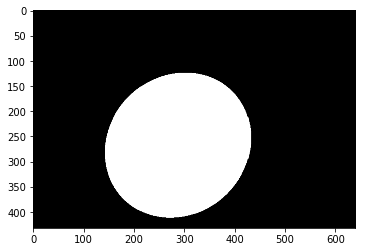

In [34]:
plt.imshow(y[0,0,:,:], cmap='gray')

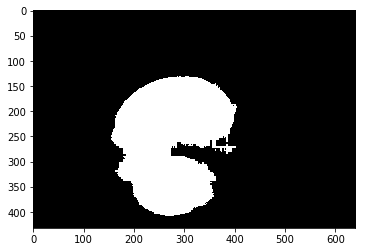

In [35]:
plt.imshow(yp.argmax(1)[0], cmap='gray')

In [0]:
model.load_state_dict(best_model)

IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [0]:
loader = iter(test_loader)

In [0]:
x, _ = next(loader)
x = x.to(device)
yp = model(x)

In [0]:
x = x.to('cpu').data.detach()

In [0]:
yp = yp.to('cpu').data.detach()

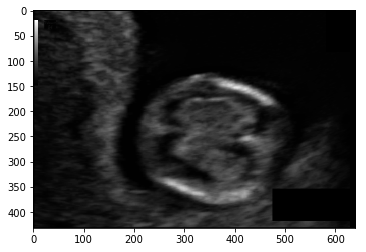

In [73]:
plt.imshow(x[1,0,:,:], cmap='gray')

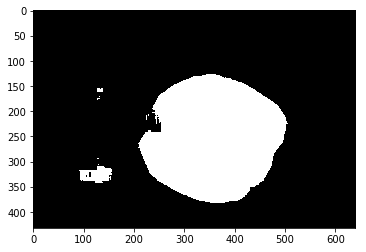

In [74]:
plt.imshow(yp.argmax(1)[1], cmap='gray')